# Homework - Vertical FL and Generative Modeling
Vertical federated learning (VFL) and generative modeling are two techniques for privacy preservation. The former enables collaborative training across vertically partitioned data. At the same time, generative modeling creates synthetic data as an alternative to using real sensitive data. In this assignment, you'll further explore some factors affecting model performance in VFL and how it can be bridged with generative modeling. 



# Instructions

Submit your assignment as a Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.

## Question 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **5** random feature permutations and plot the training loss. Report whether shuffling features significantly affects the convergence rates and the reasoning behind it.

Scoring:
- _(1 point)_ Create 5 feature permutations (shuffling done before one-hot encoding) with seeded Python/NumPy random functions and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) the permutations have on the loss and explain the observed pattern.

In [25]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm


class BottomModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(BottomModel, self).__init__()
        self.local_out_dim = out_feat
        self.fc1 = nn.Linear(in_feat, out_feat)
        self.fc2 = nn.Linear(out_feat, out_feat)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.dropout(self.act(self.fc2(x)))


class TopModel(nn.Module):
    def __init__(self, local_models, n_outs):
        super(TopModel, self).__init__()
        self.in_size = sum(
            [local_models[i].local_out_dim for i in range(len(local_models))]
        )
        self.fc1 = nn.Linear(self.in_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        concat_outs = torch.cat(x, dim=1)
        x = self.act(self.fc1(concat_outs))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.dropout(x)


class VFLNetwork(nn.Module):
    def __init__(self, local_models, n_outs):
        super(VFLNetwork, self).__init__()
        self.num_cli = None
        self.cli_features = None
        self.bottom_models = local_models
        self.top_model = TopModel(self.bottom_models, n_outs)
        self.optimizer = optim.AdamW(self.parameters())
        self.criterion = nn.CrossEntropyLoss()

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, y):
        train_losses = []
        self.num_cli = n_cli
        self.cli_features = cli_features
        x = x.astype("float32")
        y = y.astype("float32")
        x_train = [torch.tensor(x[feats].values) for feats in cli_features]
        y_train = torch.tensor(y.values)
        num_batches = (
            len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
        )
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            total_loss = 0.0
            correct = 0.0
            total = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = [x[int(minibatch * batch_sz) :] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz) :]
                else:
                    x_minibatch = [
                        x[int(minibatch * batch_sz) : int((minibatch + 1) * batch_sz)]
                        for x in x_train
                    ]
                    y_minibatch = y_train[
                        int(minibatch * batch_sz) : int((minibatch + 1) * batch_sz)
                    ]

                outs = self.forward(x_minibatch)
                pred = torch.argmax(outs, dim=1)
                actual = torch.argmax(y_minibatch, dim=1)
                correct += torch.sum((pred == actual))
                total += len(actual)
                loss = self.criterion(outs, y_minibatch)
                total_loss += loss
                loss.backward()
                self.optimizer.step()

            train_losses.append(total_loss.detach().numpy() / num_batches)
            # print(
            #     f"Epoch: {epoch} Train accuracy: {correct * 100 / total:.2f}% Loss: {train_losses[-1]:.3f}"
            # )

        return train_losses

    def forward(self, x):
        local_outs = [
            self.bottom_models[i](x[i]) for i in range(len(self.bottom_models))
        ]
        return self.top_model(local_outs)

    def test(self, x, y):
        x = x.astype("float32")
        y = y.astype("float32")
        x_test = [torch.tensor(x[feats].values) for feats in self.cli_features]
        y_test = torch.tensor(y.values)
        with torch.no_grad():
            outs = self.forward(x_test)
            preds = torch.argmax(outs, dim=1)
            actual = torch.argmax(y_test, dim=1)
            accuracy = torch.sum((preds == actual)) / len(actual)
            loss = self.criterion(outs, y_test)
            return accuracy, loss

In [26]:
import seaborn as sns


def preprocess_data(num_clients, np_seed=42):
    torch.manual_seed(42)
    np.random.seed(np_seed)
    df = pd.read_csv("heart-dataset/heart.csv")
    categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    numerical_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
    df[numerical_cols] = MinMaxScaler().fit_transform(
        df[numerical_cols]
    )  # scale numerical features for effective learning
    permutated_features = np.random.permutation(
        df.columns[:-1]
    ).tolist()  # random feature permutation
    permutated_features.append(df.columns[-1])
    df = df[permutated_features]
    encoded_df = pd.get_dummies(
        df, columns=categorical_cols
    )  # convert categorical features to one-hot embeddings
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[["target"]], columns=["target"])
    features_per_client = (num_clients - 1) * [
        (len(df.columns) - 1) // num_clients
    ]  # "equally" partition the features
    features_per_client.append(len(df.columns) - 1 - sum(features_per_client))
    features_per_client = np.array(features_per_client)
    all_feature_names = list(df.columns)
    all_feature_names.pop()
    client_feature_names = []
    csum_features_per_client = np.cumsum(features_per_client)
    encoded_df_feature_names = list(X.columns)
    start_index = 0
    end_index = 0
    for num_feats in features_per_client:
        feat_names = all_feature_names[start_index : start_index + num_feats]
        client_feature_names.append(feat_names)
        start_index = start_index + num_feats

    for i in range(len(client_feature_names)):
        updated_names = []
        for column_name in client_feature_names[i]:
            if column_name not in categorical_cols:
                updated_names.append(column_name)
            else:
                for name in encoded_df_feature_names:
                    if "_" in name and column_name in name:
                        updated_names.append(name)

        client_feature_names[i] = updated_names

    return X, Y, client_feature_names


def define_model(client_feature_names):
    # model architecture hyperparameters
    outs_per_client = 2
    bottom_models = [
        BottomModel(len(in_feats), outs_per_client * len(in_feats))
        for in_feats in client_feature_names
    ]
    final_out_dims = 2
    Network = VFLNetwork(bottom_models, final_out_dims)
    return Network


def train_model(
    Network,
    num_clients,
    epochs,
    batch_size,
    train_test_thresh,
):
    # Training configurations
    X_train, X_test = (
        X.loc[: int(train_test_thresh * len(X))],
        X.loc[int(train_test_thresh * len(X)) + 1 :],
    )
    Y_train, Y_test = (
        Y.loc[: int(train_test_thresh * len(Y))],
        Y.loc[int(train_test_thresh * len(Y)) + 1 :],
    )
    train_losses = Network.train_with_settings(
        epochs, batch_size, num_clients, client_feature_names, X_train, Y_train
    )

    accuracy, loss = Network.test(X_test, Y_test)
    print(f"Test accuracy: {accuracy * 100:.2f}%")

    return train_losses


def plot_losses(epochs, losses, seed):
    ax = sns.lineplot(x=range(epochs), y=losses, seed=0, label=f"Seed: {seed}")
    ax.set(xlabel="Epoch", ylabel="Loss")

numpy seed: 12


  1%|          | 2/300 [00:00<00:22, 13.15it/s]

100%|██████████| 300/300 [00:14<00:00, 20.17it/s]


Test accuracy: 85.29%

numpy seed: 22


100%|██████████| 300/300 [00:15<00:00, 19.13it/s]


Test accuracy: 88.73%

numpy seed: 32


100%|██████████| 300/300 [00:18<00:00, 15.82it/s]


Test accuracy: 83.33%

numpy seed: 42


100%|██████████| 300/300 [00:17<00:00, 17.25it/s]


Test accuracy: 88.73%

numpy seed: 52


100%|██████████| 300/300 [00:32<00:00,  9.28it/s]


Test accuracy: 85.29%



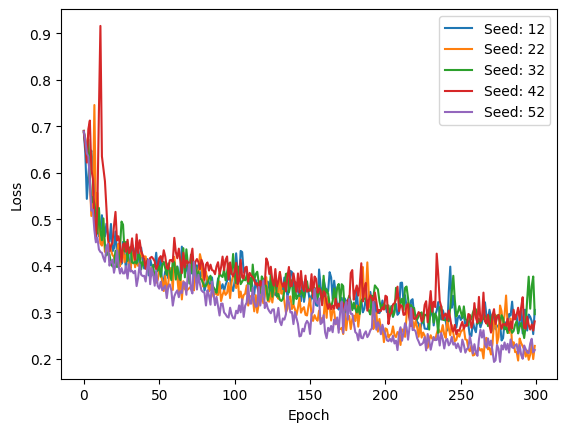

In [27]:
NUM_CLIENTS = 4
EPOCHS = 300
BATCH_SIZE = 64
TRAIN_TEST_THRESH = 0.8

np_seeds = [12, 22, 32, 42, 52]

for np_seed in np_seeds:
    print(f"numpy seed: {np_seed}")
    X, Y, client_feature_names = preprocess_data(NUM_CLIENTS, np_seed=np_seed)
    Network = define_model(client_feature_names)
    train_losses = train_model(
        Network, NUM_CLIENTS, EPOCHS, BATCH_SIZE, TRAIN_TEST_THRESH
    )
    plot_losses(EPOCHS, train_losses, np_seed)
    print()

TODO

## Question 2: Scaling clients in VFL (4 points)

With the same template code, experiment with how increasing the number of clients affects model performance. Plot the training loss with 2, 4, and 8 clients. Try a greedy partition for the features, with the remaining extra features assigned to the last client. For example, with 14 features and three clients, assign four features to clients 1 and 2 and six to client 3. Report your reasoning for the observed output.

Scoring:
- _(1 point)_ Create the greedily-partitioned feature splits for the requested client counts (use the default ordering in the dataset) and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

## Question 3: Bridging VFL and generative modeling (8 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. In this regard, combine VFL with variational autoencoders (VAEs) by following the architecture shown in the figure below. Each client uses a local network, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another MLP. Code the necessary components using the templates from [lab-vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb) and [generative_modeling.py](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/generative_modeling.py). Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features similarly to the discriminative model VFL lab.
- _(2 points)_ Define the input & output MLP networks to be used by clients.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, printing the loss at every epoch.

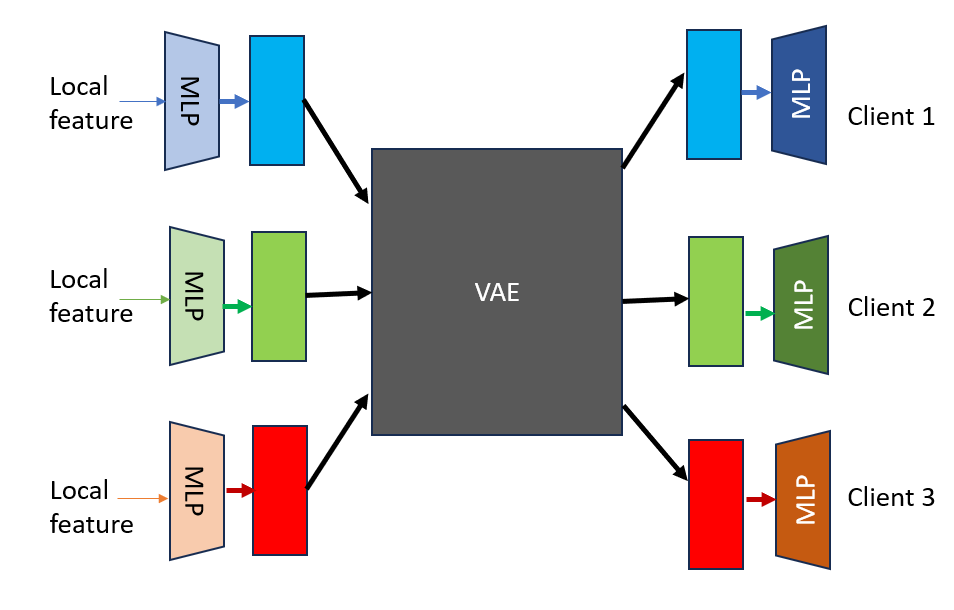
### For any questions regarding this assignment, send an email to a.shankar@tudelft.nl